In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("/home/oto/Downloads/dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

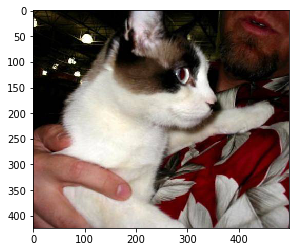

In [4]:
sample = random.choice(filenames)
image = load_img("/home/oto/Downloads/dogs-vs-cats/train/"+sample)
plt.imshow(image)

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
earlystop = EarlyStopping(patience=10)

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [9]:
callbacks = [earlystop, learning_rate_reduction]

In [10]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    '/home/oto/Downloads/dogs-vs-cats/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/home/oto/Downloads/dogs-vs-cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


In [16]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1333/1333 [==============================] - 1230s 923ms/step - loss: 0.7487 - acc: 0.6326 - val_loss: 0.6093 - val_acc: 0.6799
Epoch 2/50
1333/1333 [==============================] - 1175s 881ms/step - loss: 0.5684 - acc: 0.7138 - val_loss: 0.4631 - val_acc: 0.7836
Epoch 3/50
1333/1333 [==============================] - 1171s 878ms/step - loss: 0.5148 - acc: 0.7563 - val_loss: 0.4786 - val_acc: 0.7659
Epoch 4/50
1333/1333 [==============================] - 1179s 885ms/step - loss: 0.4746 - acc: 0.7785 - val_loss: 0.4419 - val_acc: 0.8211
Epoch 5/50
1333/1333 [==============================] - 1178s 884ms/step - loss: 0.4456 - acc: 0.7974 - val_loss: 0.3894 - val_acc: 0.8309
Epoch 6/50
1333/1333 [==============================] - 1257s 943ms/step - loss: 0.4198 - acc: 0.8094 - val_loss: 0.4303 - val_acc: 0.7998
Epoch 7/50
1333/1333 [==============================] - 1167s 875ms/step - loss: 0.4092 - acc: 0.8146 - val_loss: 0.38

In [18]:
model.save_weights("model.h5")

In [19]:
test_filenames = os.listdir("/home/oto/Downloads/dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [20]:
nb_samples

12500

In [21]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/oto/Downloads/dogs-vs-cats/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


In [22]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [23]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [24]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)